# Digikala comments classification with  RNN - LSTM
Comments classification  to find out customers recommend them or not

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tensorflow as tf

#splitting dataset
from sklearn.model_selection import train_test_split

# Building sequential model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Embedding, LSTM, Bidirectional

# Word vectorization 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Avoiding warnings
import warnings
import os
########### Prevent Warnings ###########
warnings.filterwarnings(action='ignore')
########### Prevent Warnings ###########

In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpu = gpus[0]
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
tf.config.experimental.set_memory_growth(gpu, True)

## Importing data

In [3]:
df = pd.read_csv('train.csv', index_col=[0])
df.head()

,clean_comment,recommend
0,سلام، قبل اینکه نظرم رو بگم میخواستم به یک موض...,1
1,گیره های فلزی خیلی سخت تا میشوند و لذا حوله را...,0
2,سلام دوستان،،x000D\nمنم مثه بعضی از دوستان قبل...,1
3,من چند سالی هست که این اسپیکرو خریدم و واقعا ح...,1
4,نزدیک به دو ساله که این هارد رو خریدم استفاده ...,1


## Creating train and test datasets

In [4]:
text = df['clean_comment'].astype(str).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(text, df['recommend'], test_size=0.3)
# print(X_train)
X_train = [text for text in X_train]
Y_train = [label for label in Y_train]

X_test = [text for text in X_test]
Y_test = [label for label in Y_test]
X_train, X_test, Y_train, Y_test = np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)

## Tokenizing and vectorizing data

In [5]:
max_features = 10000
sequence_length = 500

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [6]:
vectorize_layer.adapt(text)

In [7]:
X_train = vectorize_layer(X_train)

In [8]:
X_test = vectorize_layer(X_test)

In [9]:
X_test

<tf.Tensor: shape=(15925, 500), dtype=int64, numpy=
array([[  49,   24, 5032, ...,    0,    0,    0],
       [  60, 2169,    1, ...,    0,    0,    0],
       [  61,   25,   98, ...,    0,    0,    0],
       ...,
       [ 338,  901,  188, ...,    0,    0,    0],
       [ 338,    8,    4, ...,    0,    0,    0],
       [   1,  465,    1, ...,    0,    0,    0]], dtype=int64)>

# Creating the model

In [10]:
embedding_dim = 64
max_length = 16
epochs = 4
batch_size = 256


model = tf.keras.Sequential([
    Embedding(
        input_dim=max_features,
        output_dim=embedding_dim,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    Bidirectional(LSTM(64,  return_sequences=True)),

    Bidirectional(LSTM(32)),
    Dropout(0.2),
    
    Dense(64, activation='relu'),
    Dropout(0.2),
    
    Dense(1,  activation='sigmoid')
])


In [11]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


# Training the model

In [12]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(X_test, Y_test)) 

Epoch 1/4
146/146 - 33s - loss: 0.3360 - accuracy: 0.8522 - val_loss: 0.2348 - val_accuracy: 0.9069
Epoch 2/4
146/146 - 19s - loss: 0.1798 - accuracy: 0.9326 - val_loss: 0.2293 - val_accuracy: 0.9061
Epoch 3/4
146/146 - 19s - loss: 0.1457 - accuracy: 0.9472 - val_loss: 0.2513 - val_accuracy: 0.9046
Epoch 4/4
146/146 - 19s - loss: 0.1217 - accuracy: 0.9579 - val_loss: 0.2948 - val_accuracy: 0.9022


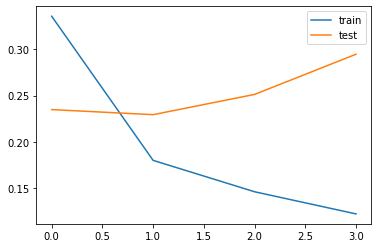

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### To confirm that this works as expected, evaluating some sentences:

In [14]:
model.predict(vectorize_layer(['خیلی بد بود']))

array([[0.23936771]], dtype=float32)

In [15]:
model.predict(vectorize_layer(['افتضاح بود']))

array([[0.04372201]], dtype=float32)

In [16]:
model.predict(vectorize_layer(['عالی بود']))

array([[0.99864143]], dtype=float32)

In [17]:
model.predict(vectorize_layer(['من از این محصول رضایت دارم']))

array([[0.99523926]], dtype=float32)

In [18]:
model.predict(vectorize_layer(['با این قیمت ارزش خرید ندارد']))

array([[0.11104872]], dtype=float32)

In [19]:
model.predict(vectorize_layer(['با این قیمت ارزش خرید دارد']))

array([[0.9712803]], dtype=float32)